# Use SARSA to Play Taxi-v3

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import gym
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Taxi-v3')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

00:00:00 [INFO] env: <TaxiEnv<Taxi-v3>>
00:00:00 [INFO] action_space: Discrete(6)
00:00:00 [INFO] observation_space: Discrete(500)
00:00:00 [INFO] reward_range: (-inf, inf)
00:00:00 [INFO] metadata: {'render.modes': ['human', 'ansi']}
00:00:00 [INFO] _max_episode_steps: 200
00:00:00 [INFO] _elapsed_steps: None
00:00:00 [INFO] id: Taxi-v3
00:00:00 [INFO] entry_point: gym.envs.toy_text:TaxiEnv
00:00:00 [INFO] reward_threshold: 8
00:00:00 [INFO] nondeterministic: False
00:00:00 [INFO] max_episode_steps: 200
00:00:00 [INFO] _kwargs: {}
00:00:00 [INFO] _env_name: Taxi


In [3]:
class SARSAAgent:
    def __init__(self, env):
        self.gamma = 0.99
        self.learning_rate = 0.2
        self.epsilon = 0.01
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        if self.mode == 'train' and np.random.uniform() < self.epsilon:
            action = np.random.randint(self.action_n)
        else:
            action = self.q[observation].argmax()
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        state, _, _, action, next_state, reward, done, next_action = \
                        self.trajectory[-8:]

        target = reward + self.gamma * \
                self.q[next_state, next_action] * (1. - done)
        td_error = target - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error


agent = SARSAAgent(env)

00:00:00 [INFO] ==== train ====
00:00:25 [INFO] ==== test ====
00:00:25 [INFO] average episode reward = 7.75 ± 2.41


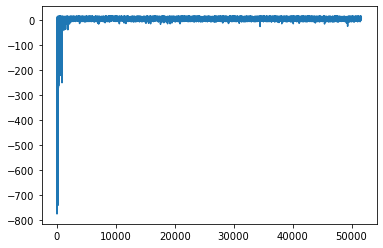

In [4]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-200:]) > 8.3:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()